In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import keras_ocr
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50 as PT_Model
# from tensorflow.keras.applications import VGG16 as PT_Model

2022-12-16 09:47:34.937331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# rec = keras_ocr.recognition.Recognizer()
# rec.compile()

In [3]:
image_size = (32, 200)
MAX_LABEL_LENGTH = 50

In [4]:
alphabet = (' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', \
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', \
            'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Å', 'Ä', 'Ö',\
            '-', ',', '/'
           )
to_alphabet = {i:key for i, key in enumerate(alphabet)}
to_class = {key:i for i,key in enumerate(alphabet)}

N_CLASSES = len(alphabet)

## Load Data

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/data_2/poly_crops",
    validation_split=0.2,
    subset="training",
    label_mode=None,
    seed=None,
    shuffle=False,
    batch_size=None,
    image_size=image_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/data_2/poly_crops",
    validation_split=0.2,
    subset="validation",
    label_mode=None,
    seed=None,
    shuffle=False,
    batch_size=None,
    image_size=image_size
)

Found 1431 files belonging to 1 classes.
Using 1145 files for training.


2022-12-16 09:47:41.796673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1431 files belonging to 1 classes.
Using 286 files for validation.


In [6]:
def scale_0_1(data):
    return data / 255

def to_gray_scale(data):
    return data[:,:,0:1]

In [7]:
#train_ds = train_ds.map(scale_0_1)
# #train_ds = train_ds.map(to_gray_scale)

#val_ds = val_ds.map(scale_0_1)
# #val_ds = val_ds.map(to_gray_scale)

### Labels

In [8]:
df = pd.read_csv('dataset/data_2/poly_labels.csv', header=None)
train_df = df.values[:len(train_ds)]
val_df = df.values[len(train_ds):]

In [9]:
train_df

array([['Plåt 2,00 mm EN AW 5754-H'],
       ['3 968, 00kg'],
       ['1 000 00kg'],
       ...,
       ['Plåt  2,00 mm EN AW 5754-H'],
       ['RP2,00-AW'],
       ['24,00kg']], dtype=object)

In [10]:
def format_labels(labels, max_len=50, n_classes=37):
    labels = labels.astype(str)
    max_length_found = np.max([len(s[0]) for s in labels])
    if (max_length_found > max_len):
        print(f'WARNING! Labels are truncated to {max_len} characters.')
    out = np.zeros((labels.shape[0], max_len, n_classes), dtype=int)

    for i,label in enumerate(labels):
        label = np.char.upper(label)[0]
        for j,char in enumerate(label):
            try:
                out[i, j, to_class[char]] = 1
            except KeyError:
                pass #out[i, j, to_class[' ']] =  1 # not a character in alphabet
        for k in range(j+1,max_len):
            out[i, k, 0] = 1
    return out

train_df = format_labels(train_df, max_len=MAX_LABEL_LENGTH, n_classes=N_CLASSES)
val_df = format_labels(val_df, max_len=MAX_LABEL_LENGTH, n_classes=N_CLASSES)

In [11]:
train_lbl = tf.data.Dataset.from_tensor_slices(train_df)
val_lbl = tf.data.Dataset.from_tensor_slices(val_df)

In [12]:
for a in train_lbl.take(1):
    print(a[0])

tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0], shape=(43,), dtype=int64)


In [13]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.zip((train_ds, train_lbl))
train_ds = train_ds.batch(BATCH_SIZE)

val_ds = tf.data.Dataset.zip((val_ds, val_lbl))
val_ds = val_ds.batch(BATCH_SIZE)

In [14]:
# for a,b in train_ds:
#     print(a.shape)
#     print(b.shape)
#     break

In [15]:
train_lbl

<TensorSliceDataset element_spec=TensorSpec(shape=(50, 43), dtype=tf.int64, name=None)>

## Model

In [46]:
pt_model = PT_Model(
    include_top=False,
    # weights='imagenet',
    input_shape=(*image_size, 3),
)
# import tensorflow as tf

# from tensorflow.keras import datasets, layers, models
# import matplotlib.pyplot as plt

pt_input = pt_model.layers[0].input
pt_output = pt_model.get_layer(name='conv3_block1_out').output
pt_model = tf.keras.Model(pt_input, pt_output)
# pt_model = models.Sequential()
# pt_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)))
# pt_model.add(layers.MaxPooling2D((2, 2)))
# pt_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# pt_model.add(layers.MaxPooling2D((2, 2)))
# pt_model.add(layers.Conv2D(64, (3, 3), activation='relu'))


def make_head(feature_shape, n_char = 50, n_classes = 37):
    inputs = tf.keras.Input(shape=feature_shape)
    x = layers.BatchNormalization()(inputs)
    x = layers.Reshape((feature_shape[-2]*feature_shape[-3], feature_shape[-1]))(x)
    x = layers.Conv1D(1024, 3, strides=2, padding='same')(x)
    x = layers.Conv1D(256,3,strides=1, padding='same')(x)
    # print(x.shape)
    x = layers.Flatten()(x)
    # print(x.shape)
    x = layers.Dense(n_char * n_classes)(x)
    outputs = layers.Reshape((n_char, n_classes))(x)
    outputs = layers.Softmax(axis=-2)(outputs)
    # # outputs = layers.LSTM(n_classes, activation='softmax', return_sequences=True)(x)
    # outputs = layers.LSTM(n_classes, activation='softmax', return_sequences=True)(x)
    # print(outputs.shape)
    return tf.keras.Model(inputs, outputs)

pt_model.trainable=True
head = make_head(pt_model.output_shape[1:], n_char = MAX_LABEL_LENGTH, n_classes=N_CLASSES)
head.summary()

N_CLASSES

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4, 25, 512)]      0         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 25, 512)       2048      
 hNormalization)                                                 
                                                                 
 reshape_4 (Reshape)         (None, 100, 512)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 1024)          1573888   
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 256)           786688    
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                           

43

In [47]:
N_CLASSES

43

In [48]:
pt_model.output_shape[1:]

(4, 25, 512)

In [49]:
pt_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 206, 3)   0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 100, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 100, 64)  256         ['conv1_conv[0][0]']       

 conv2_block3_2_conv (Conv2D)   (None, 8, 50, 64)    36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 50, 64)   256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 50, 64)   0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 50, 256)   16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

In [50]:
model = tf.keras.Sequential([
    pt_model,
    head
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 4, 25, 512)        612992    
                                                                 
 model_5 (Functional)        (None, 50, 43)            29884774  
                                                                 
Total params: 30,497,766
Trainable params: 30,491,238
Non-trainable params: 6,528
_________________________________________________________________


## Train model

In [51]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
36/36 [==============================] - 33s 855ms/step - loss: 1.9233 - categorical_accuracy: 0.5414 - val_loss: 1.0560 - val_categorical_accuracy: 0.7281
Epoch 2/10
36/36 [==============================] - 33s 924ms/step - loss: 0.4164 - categorical_accuracy: 0.8850 - val_loss: 0.5373 - val_categorical_accuracy: 0.8572
Epoch 3/10
36/36 [==============================] - 31s 863ms/step - loss: 0.2367 - categorical_accuracy: 0.9291 - val_loss: 0.3962 - val_categorical_accuracy: 0.8926
Epoch 4/10
36/36 [==============================] - 29s 803ms/step - loss: 0.1740 - categorical_accuracy: 0.9448 - val_loss: 0.3536 - val_categorical_accuracy: 0.9043
Epoch 5/10
36/36 [==============================] - 33s 909ms/step - loss: 0.1444 - categorical_accuracy: 0.9521 - val_loss: 0.3348 - val_categorical_accuracy: 0.9071
Epoch 6/10
36/36 [==============================] - 32s 891ms/step - loss: 0.1281 - categorical_accuracy: 0.9544 - val_loss: 0.3257 - val_categorical_accuracy: 0.907

In [52]:
#model.save('model/final_model_frozen.h5')

In [53]:
"""
pd.DataFrame({key:model.history.history[key] for key in model.history.history.keys() if 'loss' in key}).plot()
plt.ylim(top=1, bottom=0)
plt.xlabel('Epochs')
plt.title('Loss')
"""

"\npd.DataFrame({key:model.history.history[key] for key in model.history.history.keys() if 'loss' in key}).plot()\nplt.ylim(top=1, bottom=0)\nplt.xlabel('Epochs')\nplt.title('Loss')\n"

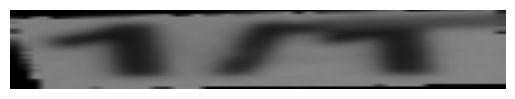

1/1                                               
1/C   Ö                                           


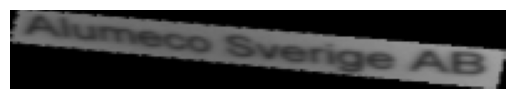

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


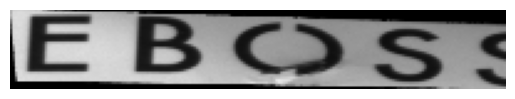

EBOSS                                             
EBFSS Ö                                           


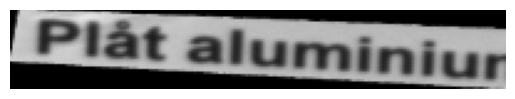

PLÅT ALUMINIUM                                    
P5YT0AÖUAI  U                                     


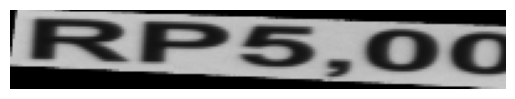

RP5,00                                            
RPF,00Ö                                           


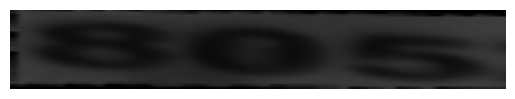

805                                               
52Y05 Ö                                           


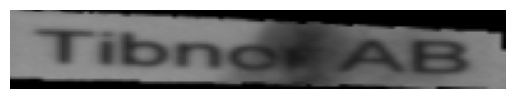

TIBNOR AB                                         
TIYNORÖAB                                         


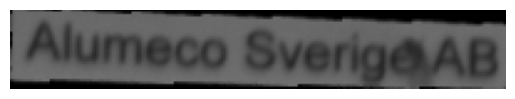

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


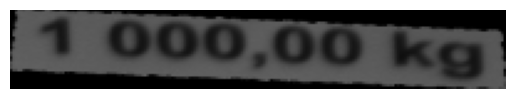

1 000,00 KG                                       
1 C00,Ö0 K                                        


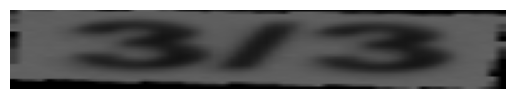

3/3                                               
3/C   Ö                                           


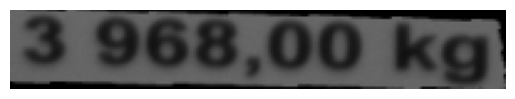

3 968,00 KG                                       
3 C68,Ö0 KG                                       


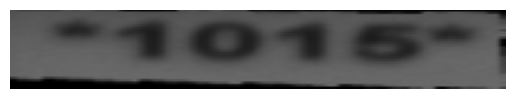

 1015                                             
11C15 Ö                                           


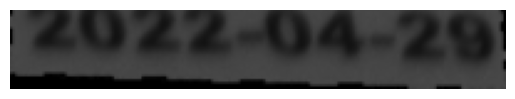

2022-04-29                                        
20Y2-0Ö-21                                        


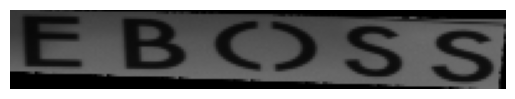

EBOSS                                             
EB8SS Ö                                           


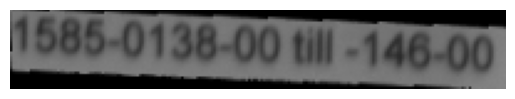

1585-0138-00 TILL-146-00                          
15Y5-0Ö38-00 TILL-146-00                          


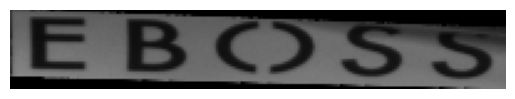

EBOSS                                             
EBDSS Ö                                           


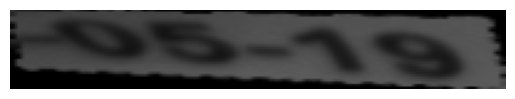

-05-19                                            
55C119Ö                                           


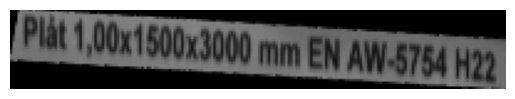

PLÅT  1,00X1500X3000 MM EN AW-5754 H22            
PLYT 1Ö0001500X3000 MMMEN AA 5754 H2H22           


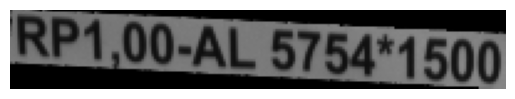

RP1,00-AL 5754 1500                               
RPY,00ÖAL 575441500                               


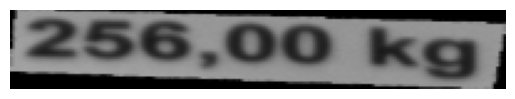

256,00 KG                                         
25C,00ÖKG                                         


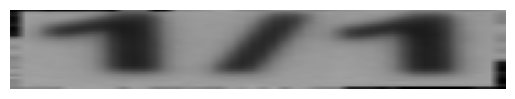

1/1                                               
1/4   Ö                                           


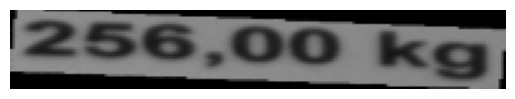

256,00 KG                                         
25C,00ÖKGKG                                       


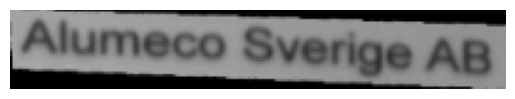

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


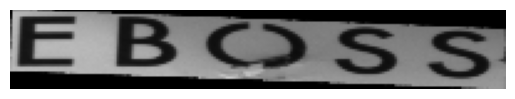

EBOSS                                             
EBDSS Ö                                           


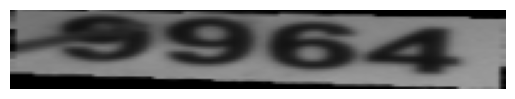

9964                                              
99C4  Ö                                           


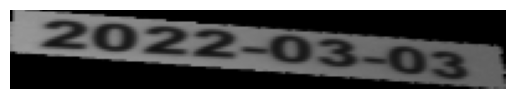

2022-03-03                                        
20Y2-0Ö-03                                        


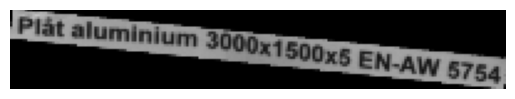

PLÅT ALUMINIUM 3000X1500X5 EN-AW 5754             
PLYT AÖUMINIUM 3000X1500X5 EN-AW 5754             


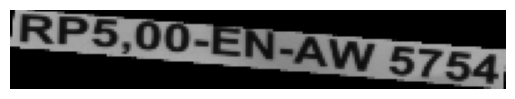

RP5,00-EN-AW 5754                                 
RPY,00ÖEN-AW 5754                                 


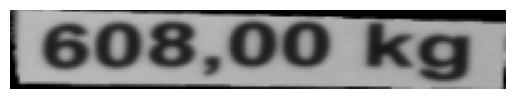

608,00 KG                                         
65C,00ÖKG                                         


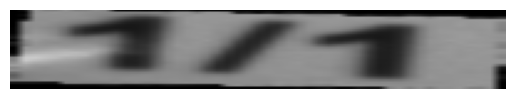

1/1                                               
1/C   Ö                                           


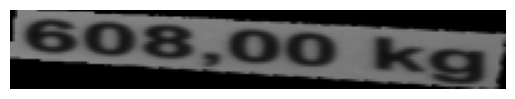

608,00 KG                                         
60Y,00ÖKG                                         


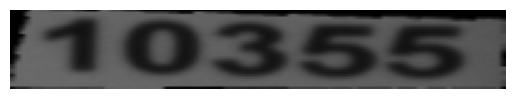

10355                                             
10Y55 Ö                                           


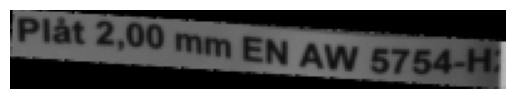

PLÅT  2,00 MM EN AW 5754-H                        
PLYT 2Ö000MM EN AW 5774-H                         


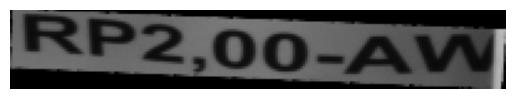

RP2,00-AW                                         
RPF200ÖAW                                         


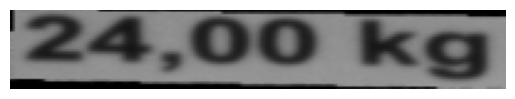

24,00 KG                                          
24C00 ÖG                                          


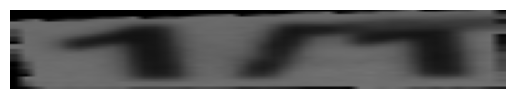

1/1                                               
1/C   Ö                                           


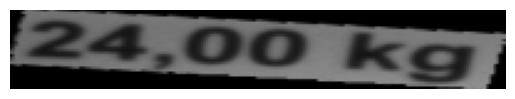

24,00 KG                                          
24D00 ÖG                                          


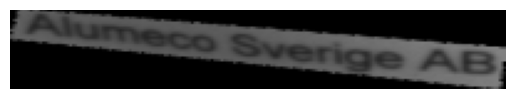

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


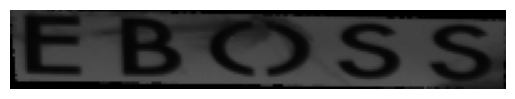

EBOSS                                             
EBDSS Ö                                           


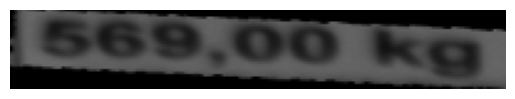

569,00 KG                                         
55Y,00ÖKG                                         


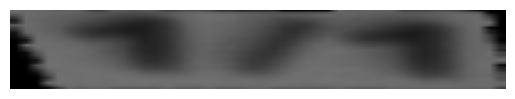

1/1                                               
1/C   Ö                                           


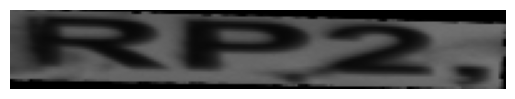

RP2,                                              
R0C20 Ö                                           


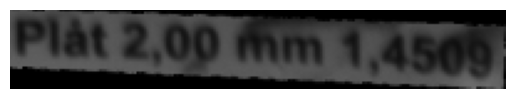

PLÅT  2,00 MM 1,4509                              
1LY000Ö A-                                        


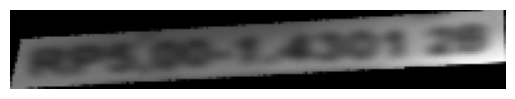

RP5,00-1 4301 2B                                  
SPY,00Ö   3    B                                  


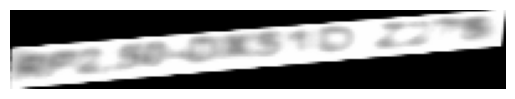

RP2,50-DX51D Z275                                 
R5/050ÖDXX D Z27                                  


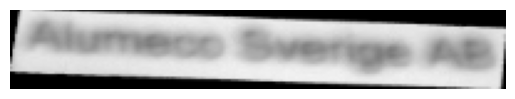

ALUMECO SVERIGE AB                                
ALUMECÖ SVERIGE AB                                


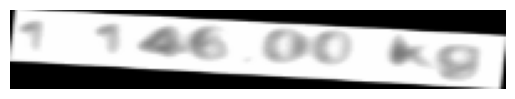

1 146,00 KG                                       
20C000Ö0                                          


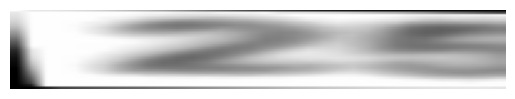

25                                                
1/Y   Ö                                           


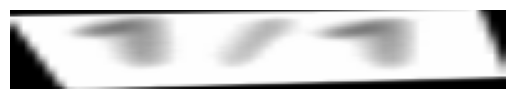

1/1                                               
1/3   Ö                                           


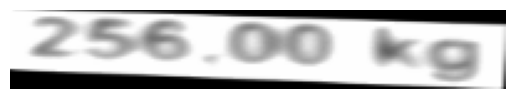

256,00 KG                                         
25C,00ÖKG                                         


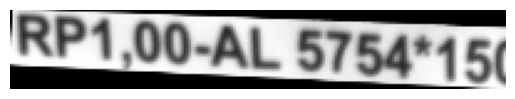

RP1,00-AL 5754 15                                 
R5J,00ÖAAW5755  A                                 


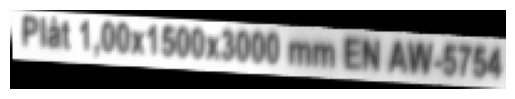

PLÅT  1,00X1500X3000 MM EN AW-5754                
PLYT AÖ00XMMU0X3000 MM  N A0 5 5X H 2             


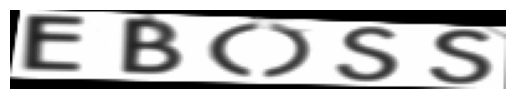

EBOSS                                             
EB3SS Ö                                           


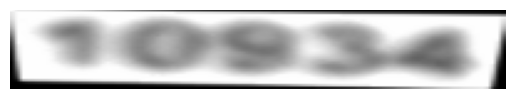

10934                                             
10C85 Ö                                           


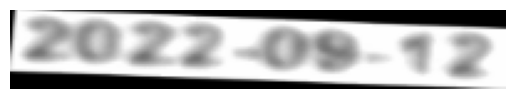

2022-09-12                                        
20F2-0Ö-28                                        


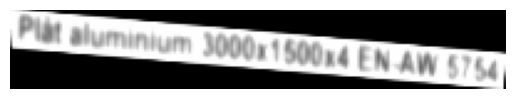

PLÅT ALUMINIUM 3000X1500X4 EN-AW  5754            
PLYT AÖUMINIUMX3000X1500X5AEN-A7 5754             


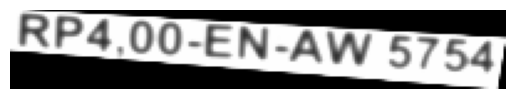

RP4,00-EN-AW 5754                                 
RPY,00ÖAN-AW557 5                                 


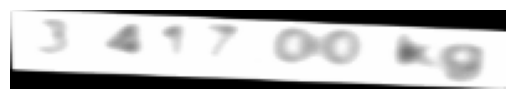

3 417,00 KG                                       
10C00 Ö0                                          


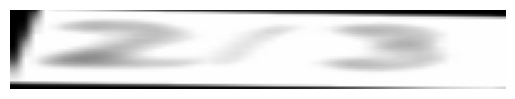

2/3                                               
1/C   Ö                                           


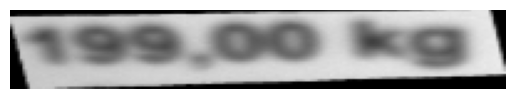

199,00 KG                                         
19C,00ÖKG                                         


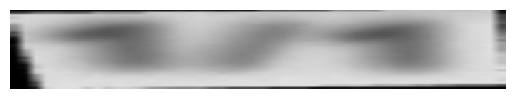

1/1                                               
1/4   Ö                                           


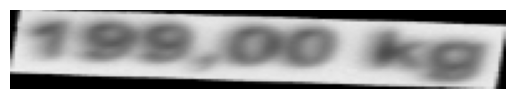

199,00 KG                                         
15C,00ÖKG                                         


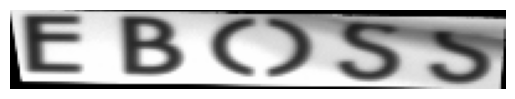

EBOSS                                             
EB3SS Ö                                           


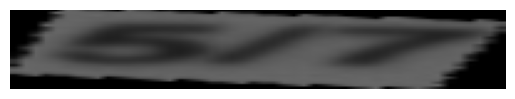

5/7                                               
1/C   Ö                                           


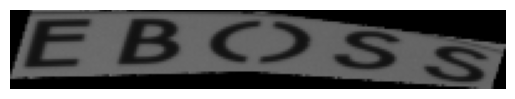

EBOSS                                             
EBFSS Ö                                           


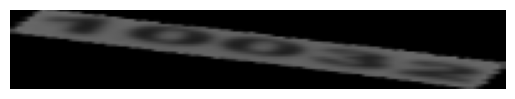

10032                                             
10Y300Ö                                           


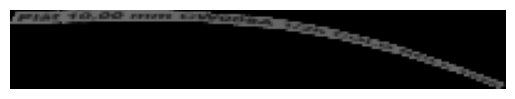

PLÅT 10,00 MM CW008A 1/2H COLD ROLL 1028          
PLYT 1Ö,00 MM 0 008A 1/2H COLD  O L 1     0 0     


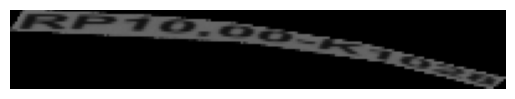

RP10,00-K1028                                     
RPY0P0Ö- 102                                      


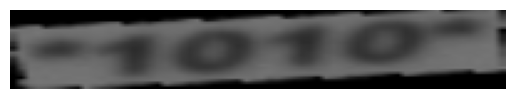

 1010                                             
11C00 Ö                                           


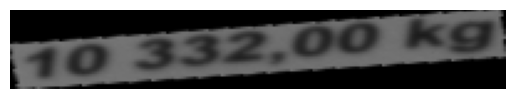

10332,00 KG                                       
R0Y,-0Ö00 K0                                      


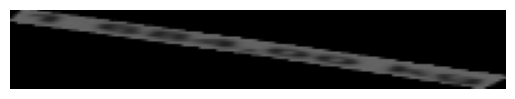

1 684,00 KG                                       
PTYTPEÖT SVER G  AB                               


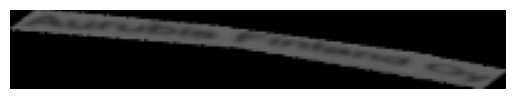

AURUBIA FINLAND DY                                
ELÄTPEÖ FVEE  E  YB                               


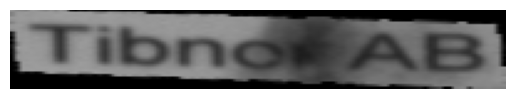

TIBNOR AB                                         
TIQNORÖAB                                         


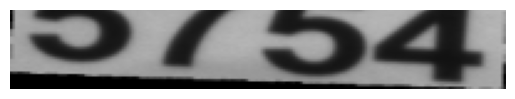

5754                                              
21Y20 Ö                                           


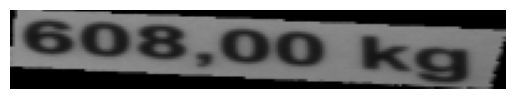

608,00 KG                                         
65Y,00ÖKG                                         


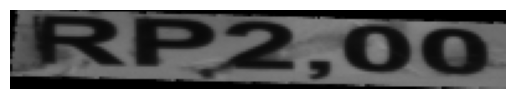

RP 2,00                                           
RPFS00Ö  0                                        


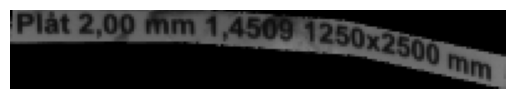

PLÅT  2,00 MM 1,4509 1250X2500 MM                 
PLYT 3Ö105MM2104509EN250X2500 MM2     2           


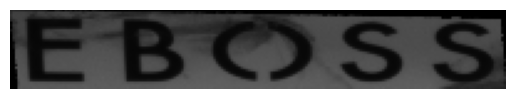

EBOSS                                             
EBDSS Ö                                           


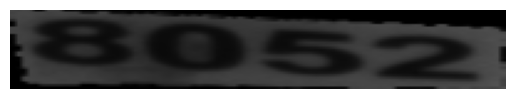

8052                                              
80C2  Ö                                           


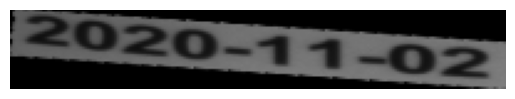

2020-11-02                                        
20Y2-0Ö-02                                        


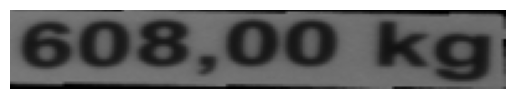

608,00 KG                                         
60Y,00ÖKGK                                        


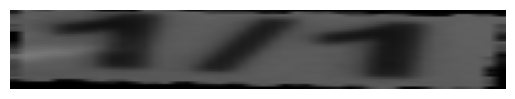

1/1                                               
1/C   Ö                                           


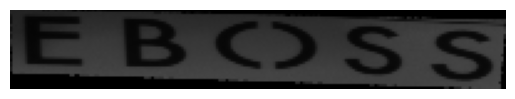

EBOSS                                             
EBDSS Ö                                           


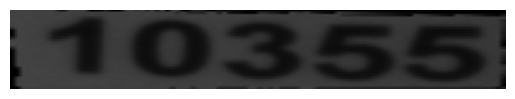

10355                                             
10Y55 Ö                                           


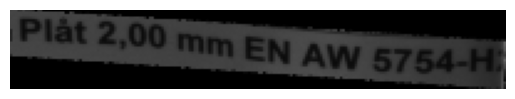

PLÅT  2,00 MM EN AW 5754-H                        
PLYT 2Ö000MM EN AW 5754-H                         


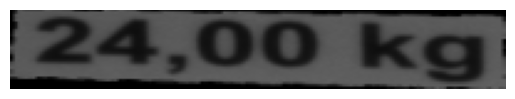

24,00 KG                                          
24C00KÖG                                          


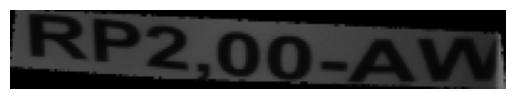

RP2,00-AW                                         
RPY,00ÖAW                                         


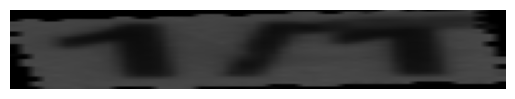

1/1                                               
1/C   Ö                                           


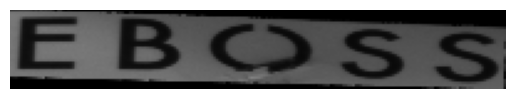

EBOSS                                             
EBDSS Ö                                           


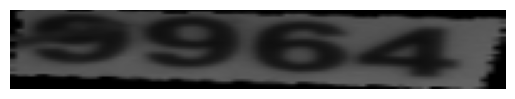

9964                                              
29C4  Ö                                           


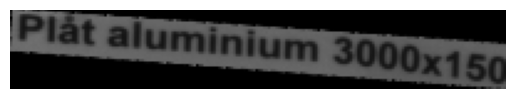

PLÅT ALUMINIUM 3000X150                           
PLYT02Ö000MM0M03A00 M5502 5                       


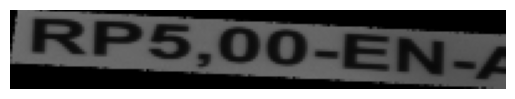

RP5,00-EN-A                                       
RPY,00Ö W                                         


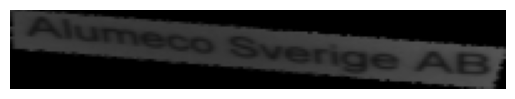

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


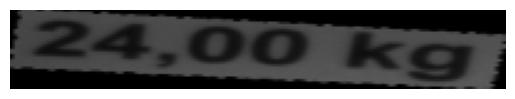

24,00 KG                                          
24C00 ÖG                                          


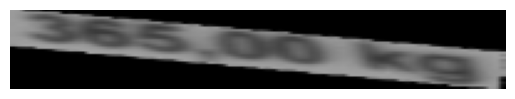

365,00 KG                                         
36Y,00ÖKG                                         


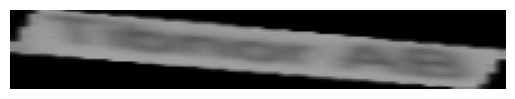

TIBNOR AB                                         
TIYNORÖAB                                         


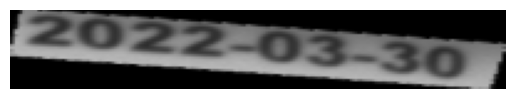

2022-03-30                                        
20Y2-0Ö-30                                        


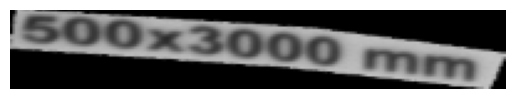

500X3000 MM                                       
30Y000Ö-00                                        


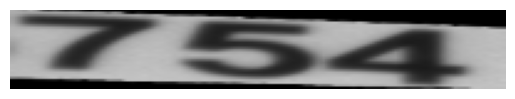

754                                               
70C0  Ö                                           


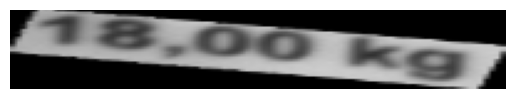

18,00 KG                                          
28Y00 ÖG                                          


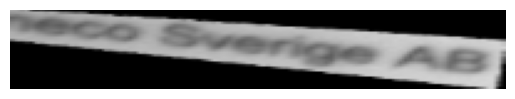

MECO SVERIGE AB                                   
ALYM0CÖASV R    A                                 


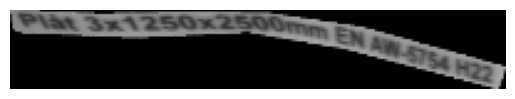

PLÅT 3X1250X2500MM EN AW-5754 H22                 
PLYT 3Ö1250X2500MMMEENAWW5554 HH2                 


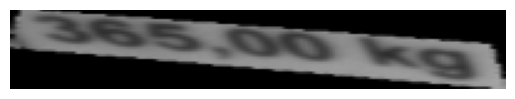

365,00 KG                                         
36Y,00Ö G                                         


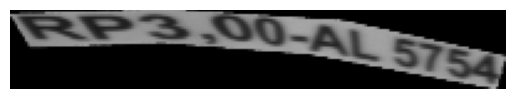

RP3 00-AL 5754                                    
RPY,00ÖAL 5754                                    


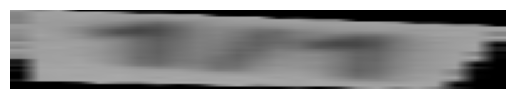

1/1                                               
1/Y   Ö                                           


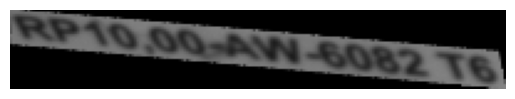

RP10,10-AW-6082 T6                                
RPY000Ö-AW--082 T6                                


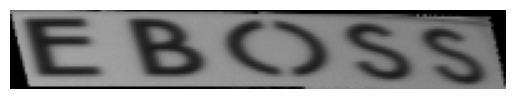

EBOSS                                             
EB3SS Ö                                           


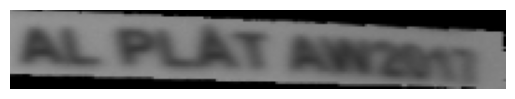

AL PLAT AW2017                                    
ALQPLAÖ AW                                        


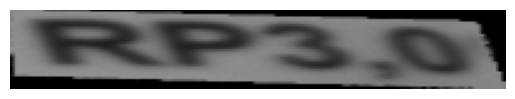

RP3,0                                             
RPC,0 Ö                                           


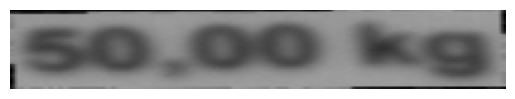

50,00 KG                                          
50C00 ÖG                                          


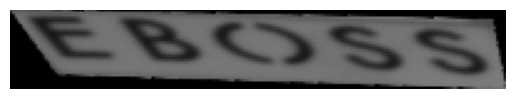

EBOSS                                             
EBCSS Ö                                           


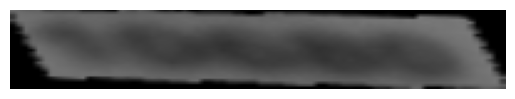

10680                                             
9LY89 Ö                                           


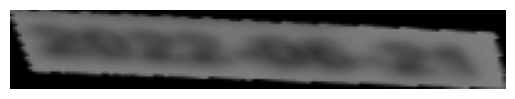

2022-06-21                                        
20C2-0Ö 2                                         


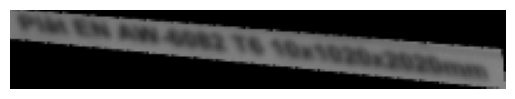

PLÅT EN AW-6082 T6 10X1020X2020 MM                
PLYTPEÖ AWER082 A6 10X1120X2020 MM                


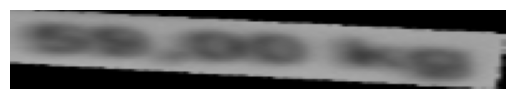

59,00 KG                                          
59Y000ÖK                                          


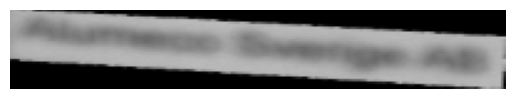

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


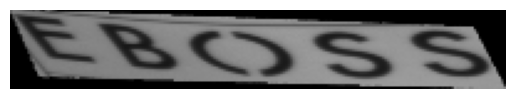

EBOSS                                             
EBDSS Ö                                           


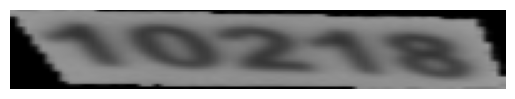

10218                                             
10C88 Ö                                           


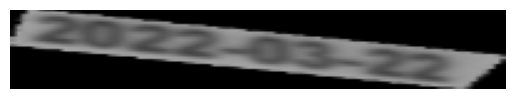

2022-03-22                                        
20Y2-0Ö-22                                        


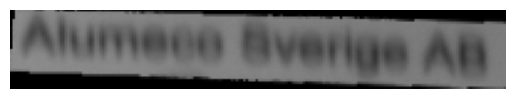

ALUMECO SVERIGE AB                                
ALYMECÖ AVERIGE AA                                


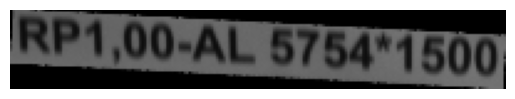

RP1,00-AL 5754 1500                               
RPY,00ÖAA 5754415000                              


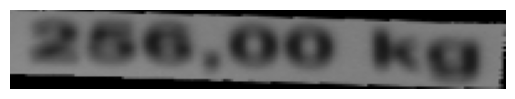

256,00 KG                                         
25C,00ÖKG                                         


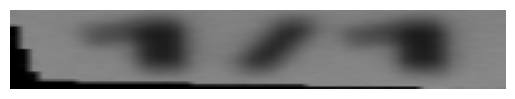

1/1                                               
1/4   Ö                                           


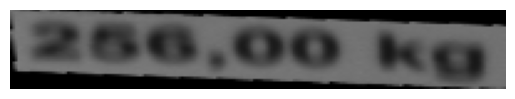

256,00 KG                                         
25C,00ÖKG                                         


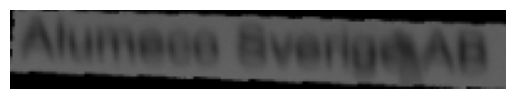

ALUMECO SVERIGE AB                                
ALYMECÖ AVERIGE AA                                


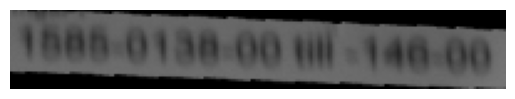

1585-0138-00 TILL-146-00                          
15YTPCÖ A100 TILL-146-00                          


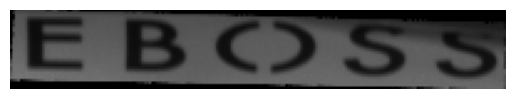

EBOSS                                             
EBDSS Ö                                           


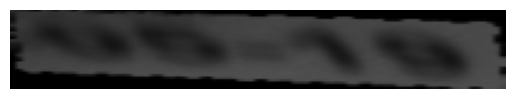

05-19                                             
35C19 Ö                                           


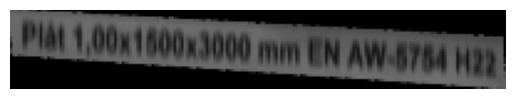

PLÅT  1,00X1500X3000 MM EN AW-5754 H22            
PLYT 1Ö00X1500X3000 MMMENAAW 5754 H222            


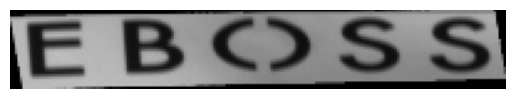

EBOSS                                             
EBDSS Ö                                           


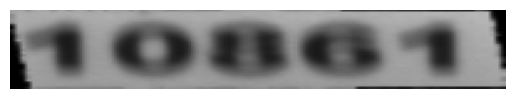

10861                                             
10C51 Ö                                           


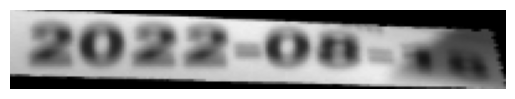

2022-08-18                                        
20Q2-0Ö-18                                        


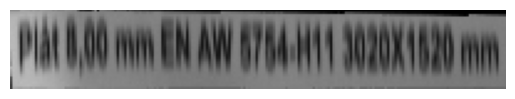

PLÅT 8,00 MM EN AW 5754-H11 3020X1520             
PLYT 8Ö005NM0ANXAW557541H1123025X1520 MM          


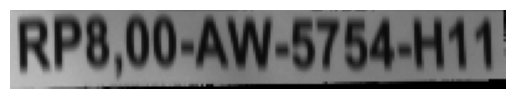

RP8,00-AW-5754-H11                                
RPY,00ÖAW-5754-H11                                


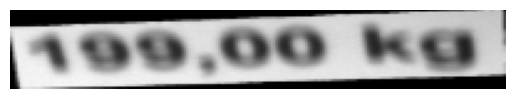

199,00 KG                                         
19C,00ÖKG                                         


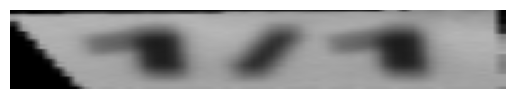

1/1                                               
1/7   Ö                                           


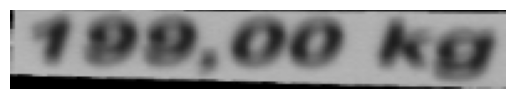

199,00 KG                                         
16C,00Ö G                                         


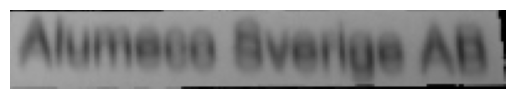

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGG AA                                


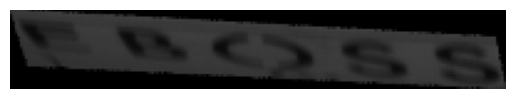

EBOSS                                             
EBYSS Ö                                           


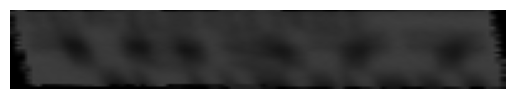

10377                                             
10Y77 Ö                                           


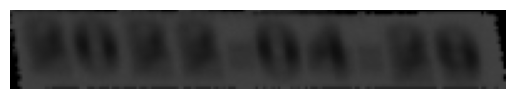

2022-04-29                                        
PLY25 Ö- 1                                        


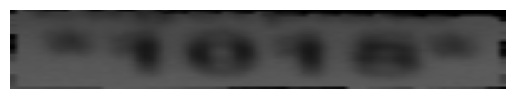

 1015                                             
11V15 Ö                                           


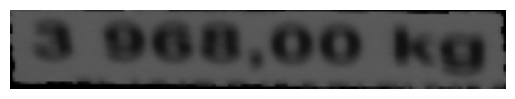

3 968,00 KG                                       
5 C68,Ö0 KG                                       


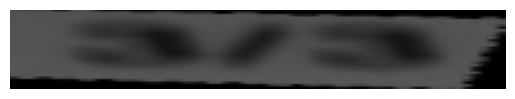

3/3                                               
1/C4  Ö                                           


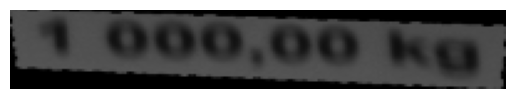

1,000,00 KG                                       
2 C00,Ö0                                          


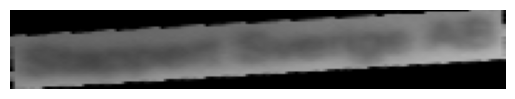

STAPPERT SVERIGE AB                               
STÄPPEÖT SVERBGE AB                               


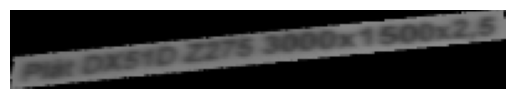

PLÅT DX51D Z275 3000X1500X2,5                     
PLYT DÖ51D Z27G 3000X1500X2,5                     


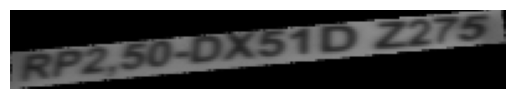

RP2,50-DX51D Z275                                 
RPY,50ÖDX51D Z275  0                              


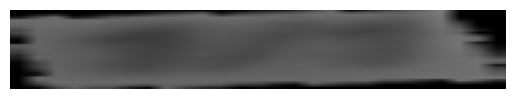

1/1                                               
1/V   Ö                                           


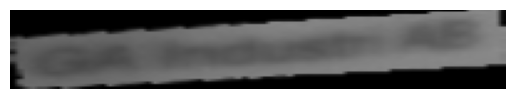

GA INDUSTRI AB                                    
GAÄINDÖS R  AB                                    


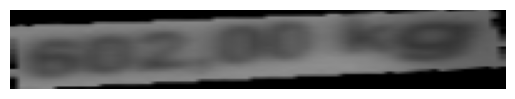

602,00 KG                                         
60Ä000ÖKG                                         


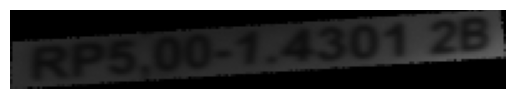

RP5,00-1 4301 2B                                  
RPY,00Ö1 4301 2B                                  


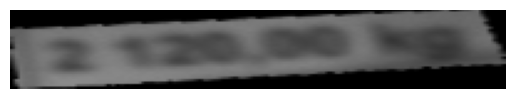

2 120,00 KG                                       
8 Y80 ÖK                                          


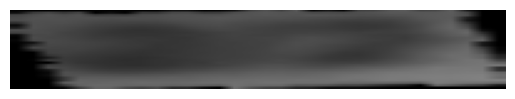

2/2                                               
2/Ä   Ö                                           


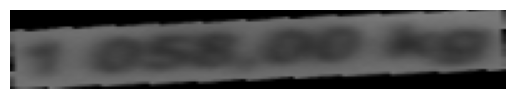

1 058,00 KG                                       
1 C50,Ö0 K                                        


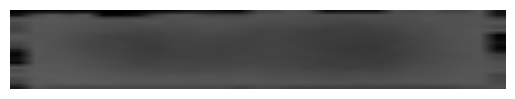

1/3                                               
1/Y   Ö                                           


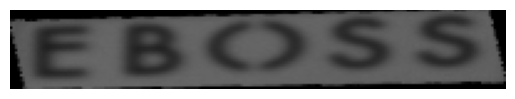

EBOSS                                             
EBCSS Ö                                           


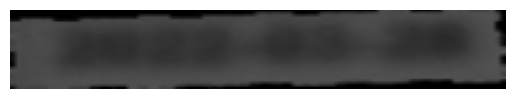

2022-03-28                                        
20Z0  Ö                                           


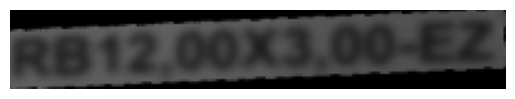

RB12,00X3,00-EZ                                   
20Y000Ö0                                          


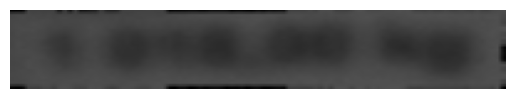

1 018,00 KG                                       
12C2  Ö                                           


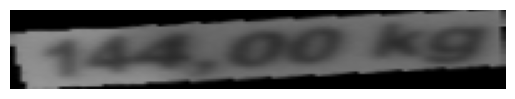

144,00 KG                                         
10Y,00Ö                                           


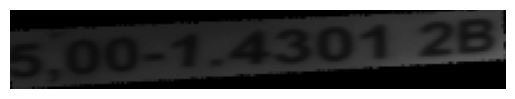

5,00-1 4301 2B                                    
RPY,00Ö1  3   2B                                  


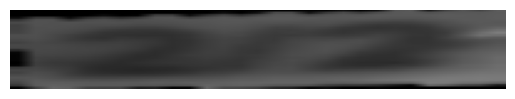

2/2                                               
O/Ä   Ö                                           


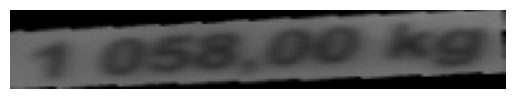

1 058,00 KG                                       
1 Y58,Ö0 KG                                       


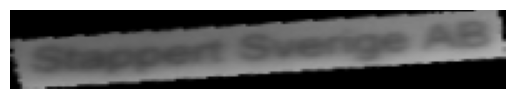

STAPPERT SVERIGE AB                               
STÄPPEÖT SVERIGE AB                               


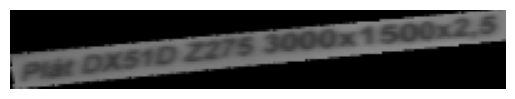

PLÅT DX51D Z275 3000X1500X2,5                     
PLYT DÖ51D Z275 3000X1500X2,5                     


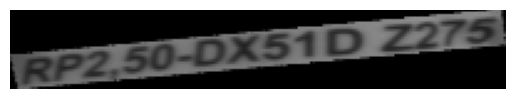

RP2,50-DX51D Z275                                 
RPY,50Ö0X51D Z275                                 


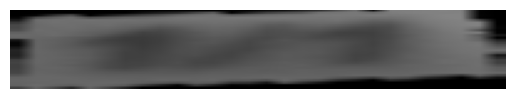

1/1                                               
1/C   Ö                                           


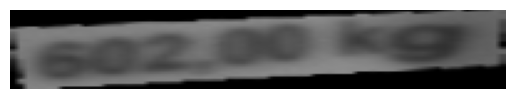

602,00 KG                                         
60C,00Ö G                                         


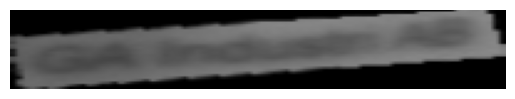

GA INDUSTRI AB                                    
GAÄINDÖS RI AB                                    


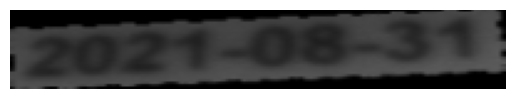

2021-08-31                                        
20Ä1-0Ö-31                                        


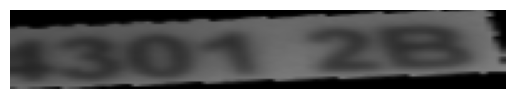

4301-2B                                           
R0Q80 Ö                                           


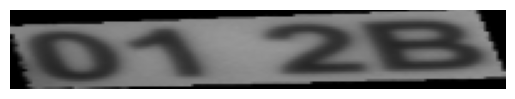

01 2B                                             
1BC,8 Ö                                           


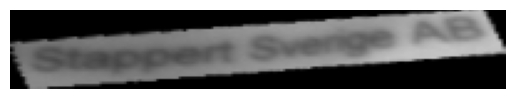

STAPPERT SVERIGE AB                               
ST/PPEÖT SVERIGE AB                               


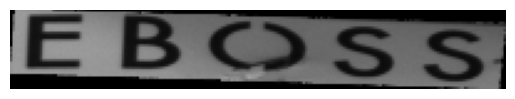

EBOSS                                             
EB9SS Ö                                           


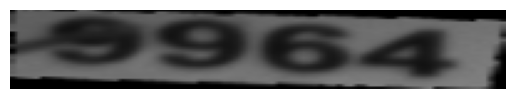

9964                                              
99C4  Ö                                           


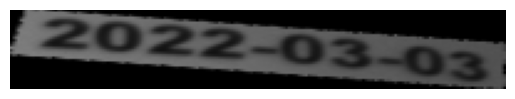

2022-03-03                                        
20Y200Ö-03                                        


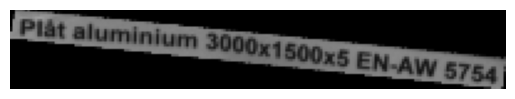

PLÅT ALUMINIUM 3000X1500X5 EN-AW 5754             
PLYT AÖUMINIUM 3000X1500X5 EN-AW 5754             


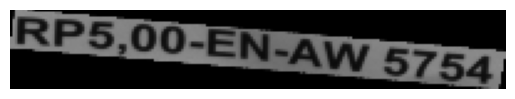

RP5,00-EN-AW 5754                                 
RPY,00ÖEN-EW 5754                                 


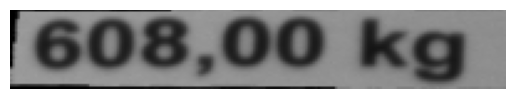

608,00 KG                                         
60Y,00ÖKG                                         


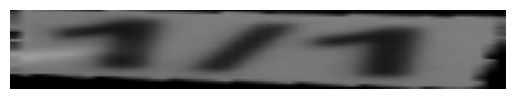

1/1                                               
1/0   Ö                                           


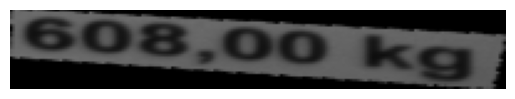

608,00 KG                                         
60Y,00ÖKG                                         


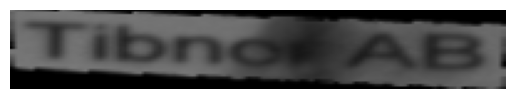

TIBNOR AB                                         
TIQNORÖAB                                         


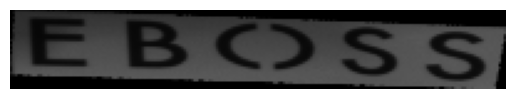

EBOSS                                             
EBDSS Ö                                           


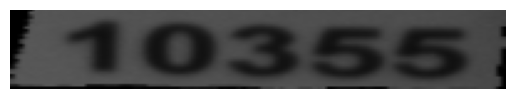

10355                                             
10X55 Ö                                           


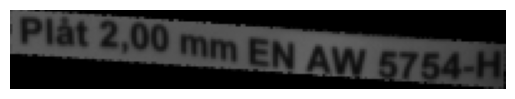

PLÅT 2,00 MM EN AW 5754-H                         
PLYT 2Ö00 MM EN AW 5754-HH                        


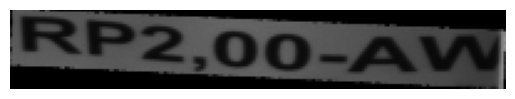

RP2,00-AW                                         
RPU,00ÖAW                                         


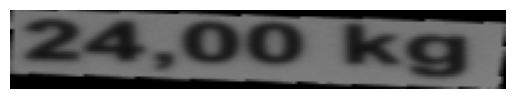

24,00 KG                                          
24C00 ÖG                                          


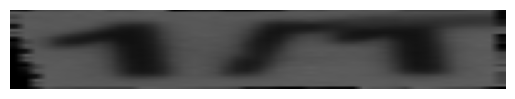

1/1                                               
1/C   Ö                                           


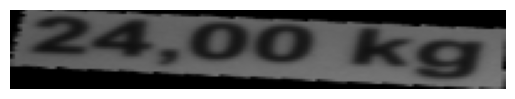

24,00 KG                                          
24Q00 ÖG                                          


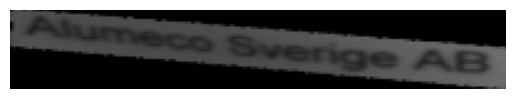

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


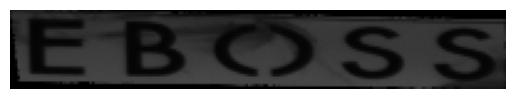

EBOSS                                             
EBDSS Ö                                           


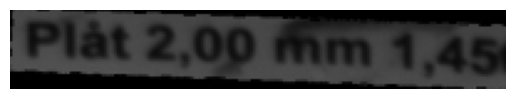

PLÅT 2,00 MM 1,45                                 
1LY1-0Ö A                                         


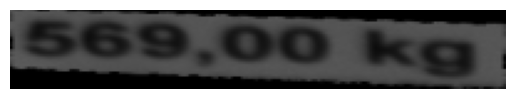

569,00 KG                                         
15C,00ÖKG                                         


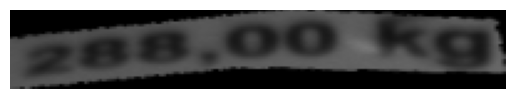

288,00 KG                                         
2PY,00Ö                                           


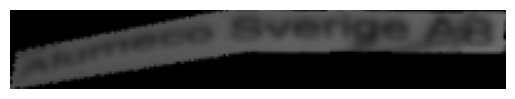

ALUMECO SVERIGE AB                                
PLYT 5ÖDX MM CX   A 1 2                X          


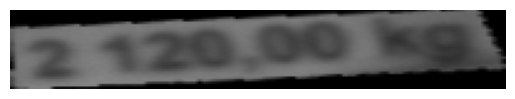

2 120,00 KG                                       
2 V20,Ö0 KG                                       


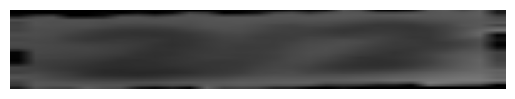

2/2                                               
2/Ä   Ö                                           


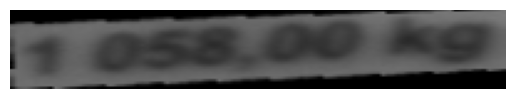

1 058,00 KG                                       
1 C58,Ö0 K                                        


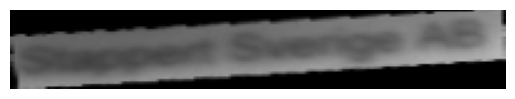

STAPPERT SVERIGE AB                               
STÄPPEÖT SVERIGE AB                               


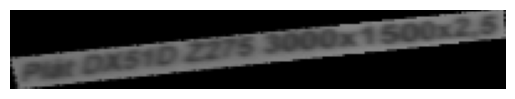

PLÅT DX51D Z275 3000X1500X2,5                     
PLYT DÖ51D Z27G 3000X1500X2,5                     


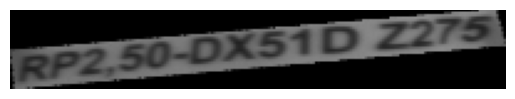

RP2,50-DX51D Z275                                 
RPY,50ÖDX51D Z275                                 


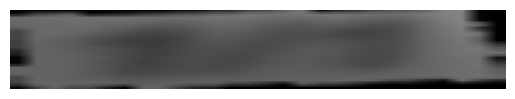

1/1                                               
1/C   Ö                                           


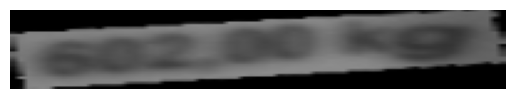

602,00 KG                                         
60Ä,00ÖK                                          


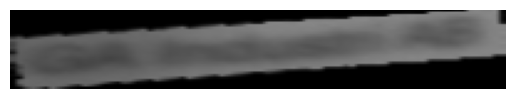

GA INDUSTRI AB                                    
GAÄINDÖSTRI AB                                    


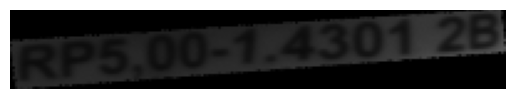

RP5,00-1 4301 2B                                  
RPY,00Ö1 4301 2B                                  


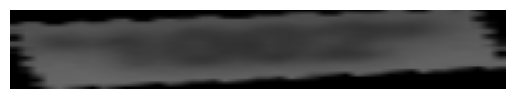

 1002                                             
9/Y 2 Ö                                           


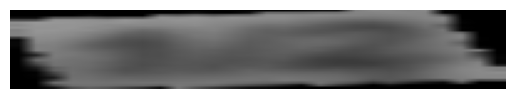

1/2                                               
1/Y   Ö                                           


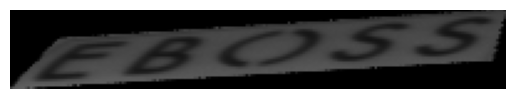

EBOSS                                             
EBYSS Ö                                           


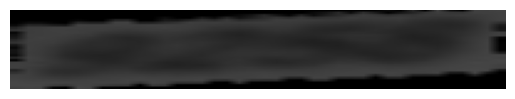

9258                                              
92Ä8  Ö                                           


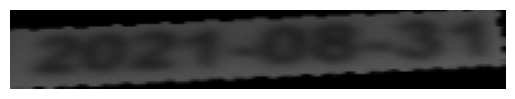

2021-08-31                                        
20Ä1-0Ö-31                                        


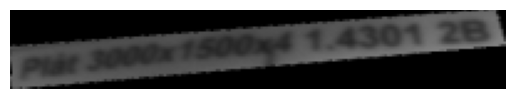

PLÅT 3000X1500X4 1 4301 2B                        
PLYT 3Ö00X1500X4 1B4301 2B                        


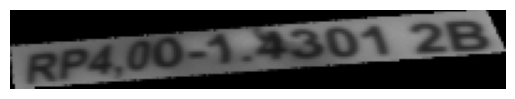

RP4,00-1 4301 2B                                  
RPY,00Ö1X4301 2B                                  


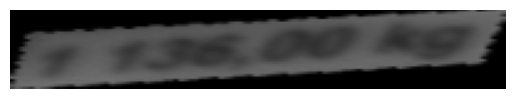

1 136, 00 KG                                      
1 C100Ö0 K                                        


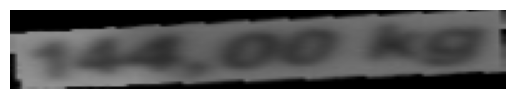

144,00 KG                                         
10Ä,00ÖKG                                         


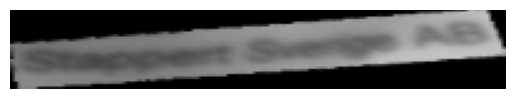

STAPPERT SVERIGE AB                               
ST/PPEÖT SVERIGE AB                               


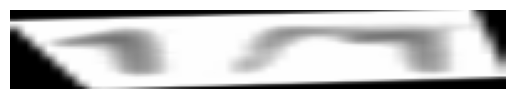

1/1                                               
1/4   Ö                                           


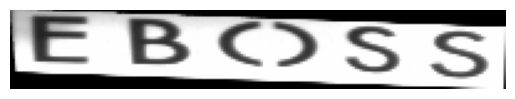

EBOSS                                             
EB3SS Ö                                           


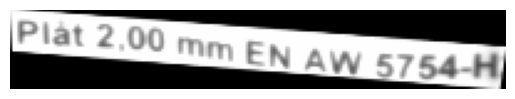

PLÅT  2,00 MM EN AW 5754-H                        
PLYT02Ö00 MM EN AW 5754-H                         


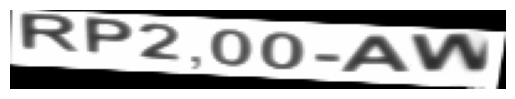

RP2,00-AW                                         
RPF200ÖAW                                         


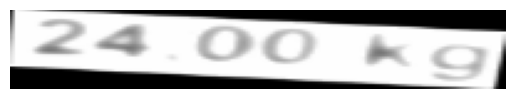

24,00 KG                                          
24J00 ÖG                                          


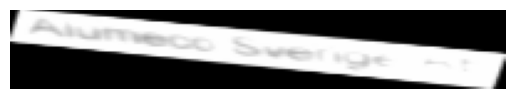

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


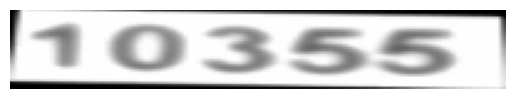

10355                                             
10C55 Ö                                           


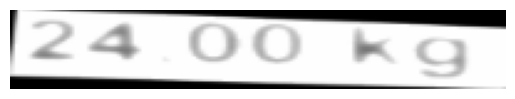

24,00 KG                                          
25D00 ÖG                                          


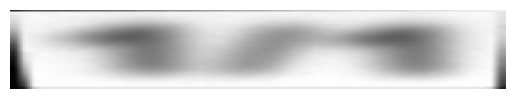

1/1                                               
1/4   Ö                                           


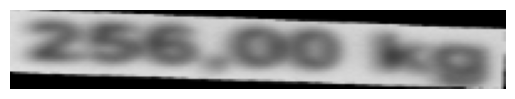

256,00 KG                                         
25C,00ÖKG                                         


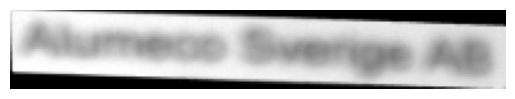

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGO AB                                


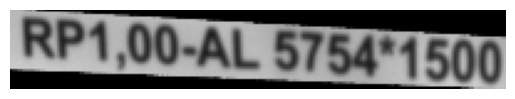

RP1,00-AL 5754 1500                               
RPJ,00ÖAL 5754 1500                               


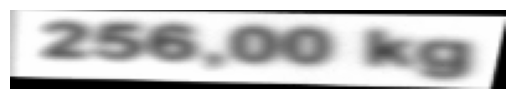

256,00 KG                                         
25C,00ÖKG                                         


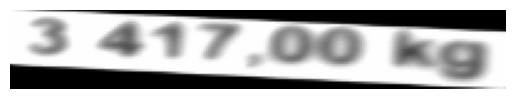

3 417,00 KG                                       
20C000Ö0 K                                        


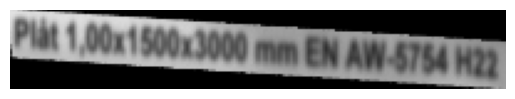

PLÅT 1,00X1500X3000 MM EN AW-5754 H22             
PLYT 1Ö00X1500X3000 MM EN AW-5754 H22             


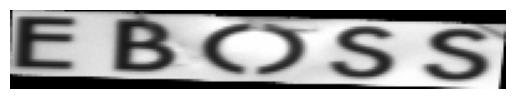

EBOSS                                             
EBDSS Ö                                           


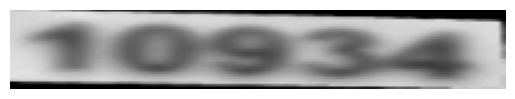

10934                                             
10C85 Ö                                           


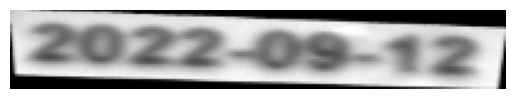

2022-09-12                                        
20C2-0Ö-2                                         


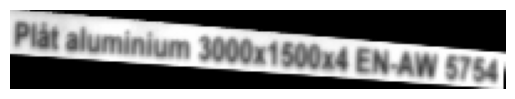

PLÅT ALUMINIUM 3000X1500X4 EN-AW 5754             
PLYT AÖUMXNIUMX3000XM50EX5AEN-57557H4             


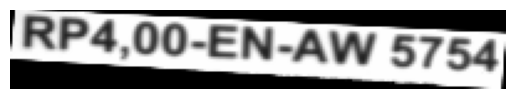

RP4,00-EN-AW 5754                                 
RPY,00Ö0N-5W557 4                                 


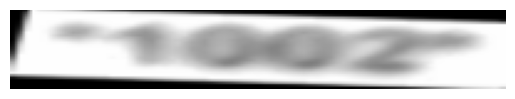

 1002                                             
11C45 Ö                                           


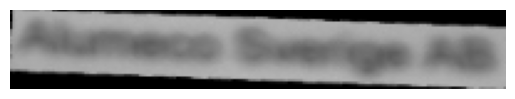

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


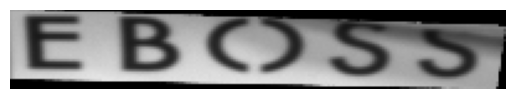

EBOSS                                             
EBDSS Ö                                           


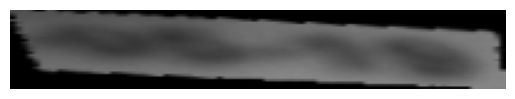

05-19                                             
25YP9 Ö9                                          


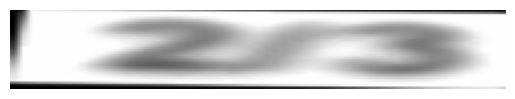

2/3                                               
1/C   Ö                                           


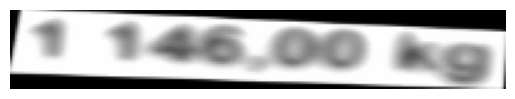

1 146 00 KG                                       
19C20 Ö0 K                                        


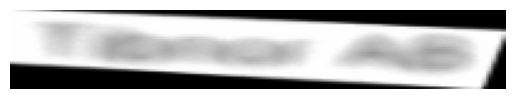

TIBNOR AB                                         
TIQP0RÖAB                                         


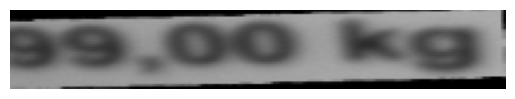

99,00 KG                                          
19C000ÖK                                          


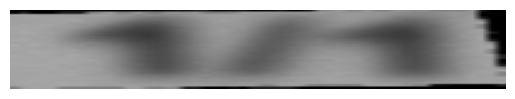

1/1                                               
1/4   Ö                                           


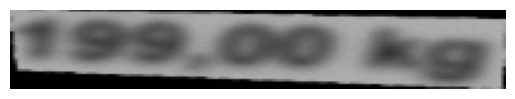

199,00 KG                                         
15C,00ÖKG                                         


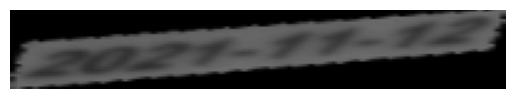

2021-11-12                                        
20Y1-1Ö-12                                        


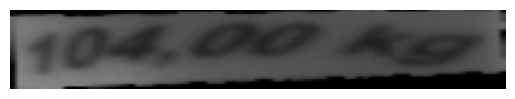

104,00 KG                                         
10C,00ÖKG                                         


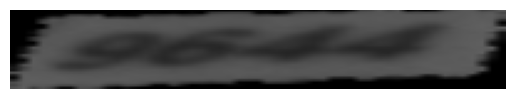

9644                                              
96Y4  Ö                                           


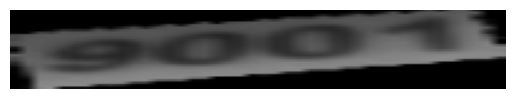

9001                                              
90Ä1  Ö                                           


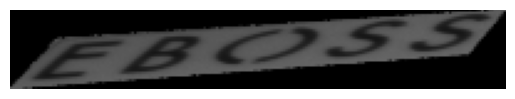

EBOSS                                             
EBWSS Ö                                           


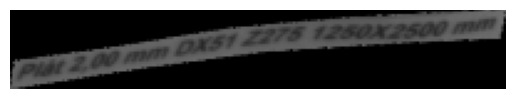

PLÅT  2,00 MM DX51 Z275 1250X2500 MM              
PLYT 2Ö00 MM DX51 Z275 1250X2500 MM               


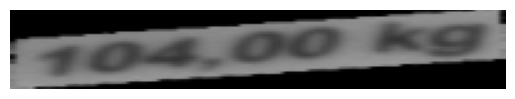

104,00 KG                                         
10Q,00ÖK                                          


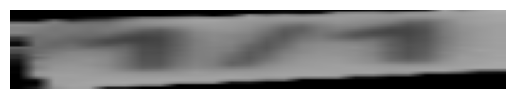

1/1                                               
1/C   Ö                                           


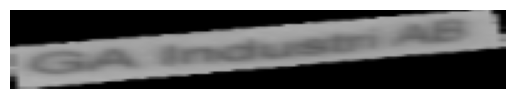

GA INDUSTRI AB                                    
GAÄINDÖSTRI AB                                    


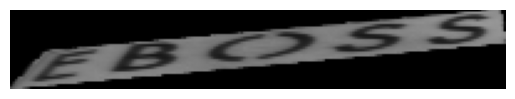

EBOSS                                             
EBWSS Ö                                           


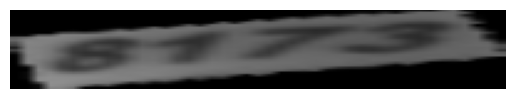

8173                                              
81Ä3  Ö                                           


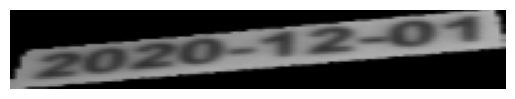

2020-12-01                                        
20Y0-1Ö-01                                        


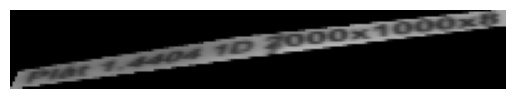

PLÅT 1 4404 1D 2000X1000X8                        
PLYT 1Ö4404 1D 2000X1100X8                        


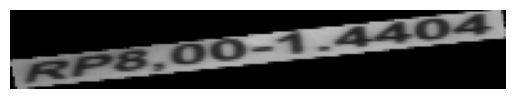

RP8,00-1 4404                                     
RPY,00Ö1 4404                                     


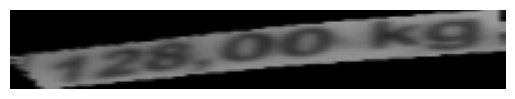

128,00 KG                                         
12M,00Ö                                           


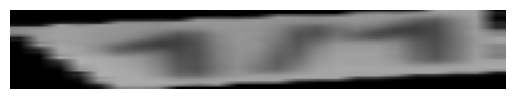

1/1                                               
1/C   Ö                                           


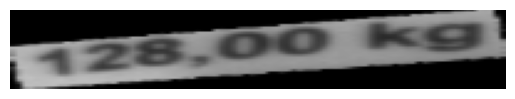

128,00 KG                                         
12M,00ÖKG                                         


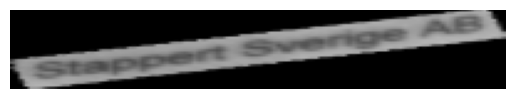

STAPPERT SVERIGE AB                               
STYPPEÖT SVERIGE AB                               


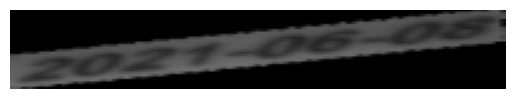

2021-06-06                                        
2LY1-DÖ-08                                        


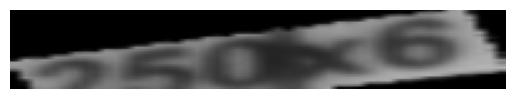

250X6                                             
20Ä100Ö                                           


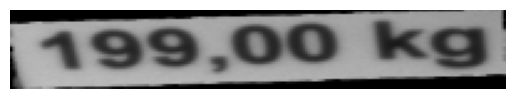

199,00 KG                                         
15C,00ÖKG                                         


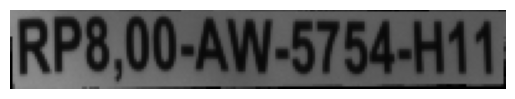

RP8,00-AW-5754-H11                                
RPY,00ÖAW-5754-H11                                


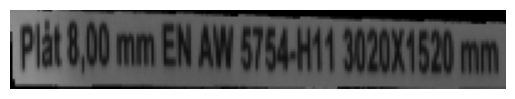

PLÅT 8,00 MM EN AW 5754-H11 3020X1520 MM          
PLYT 8Ö000MM E0 AW55754-H10 0020X1520 MM          


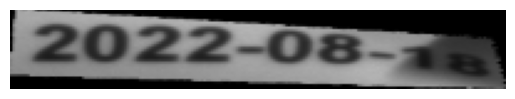

2022-08-18                                        
20C2-0Ö-18                                        


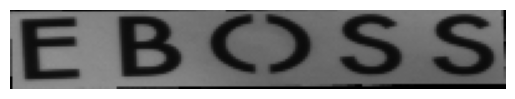

EBOSS                                             
EBWSS Ö                                           


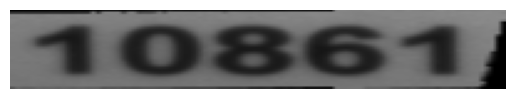

10861                                             
10Y61 Ö                                           


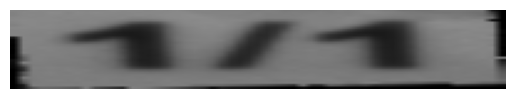

1/1                                               
1/7   Ö                                           


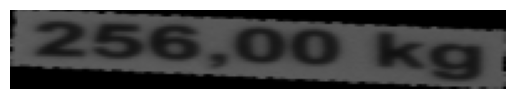

256,00 KG                                         
25Y,00ÖKG                                         


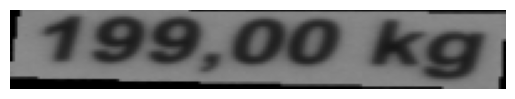

199,00 KG                                         
55C,00ÖK                                          


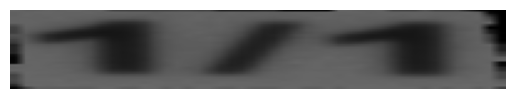

1/1                                               
1/C   Ö                                           


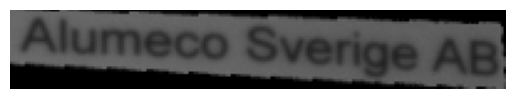

ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


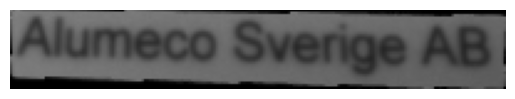

ALUMECO SVERIGE AB                                
ALUMECÖ SVERIGE AB                                


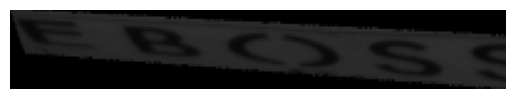

EBOSS                                             
EBY0S Ö                                           


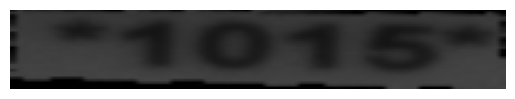

 1015                                             
11C15 Ö                                           


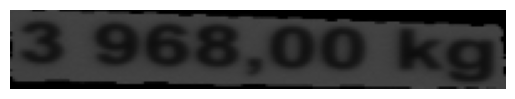

3 968,00 KG                                       
3 C68,Ö0 KK                                       


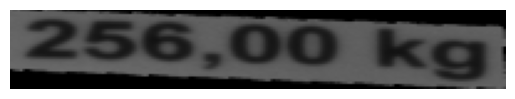

256,00 KG                                         
25C,00ÖKG                                         


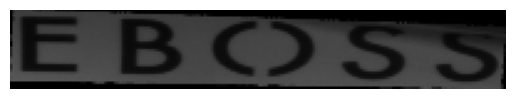

EBOSS                                             
EBDSS Ö                                           


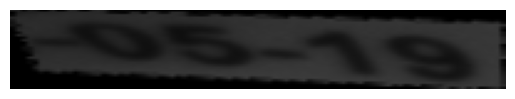

-05-19                                            
30C19 Ö                                           


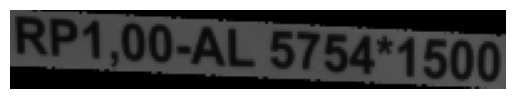

RP1,00-AL 5754 1500                               
RPY,00ÖAAL5754415000                              


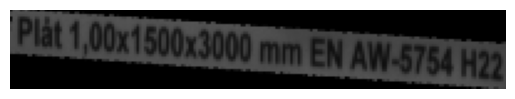

PLÅT 1,00X1500X3000 MM EN AW-5754 H22             
PLYT 1Ö00X1500X3000 MMMEN5AWW5754 HH222           


In [54]:
test_ds = val_ds.unbatch()
for img, label in test_ds.take(-1):
#    print(img.shape)
    y = np.argmax(label, 1)
    plt.imshow(img / 256)
    plt.axis('off')
    plt.show()
    plt.close()
    
    y_ = model(np.reshape(img, (1, 32, 200, 3)))
    y_ = np.argmax(y_, 2)
#    print(y_.shape)
#    print(y.shape)
    print(''.join([to_alphabet[a] for a in y]))
    print(''.join([to_alphabet[a] for a in y_[0]]))

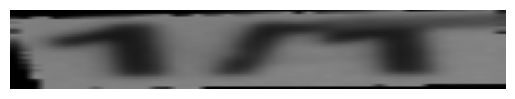

(1, 50)
(50,)
1/1                                               
1/C   Ö                                           


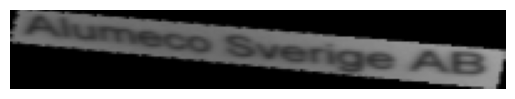

(1, 50)
(50,)
ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


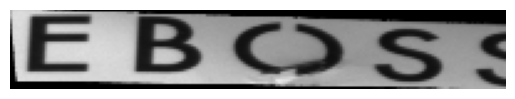

(1, 50)
(50,)
EBOSS                                             
EBFSS Ö                                           


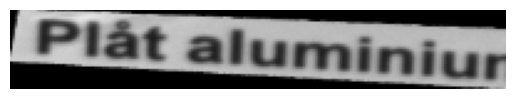

(1, 50)
(50,)
PLÅT ALUMINIUM                                    
P5YT0AÖUAI  U                                     


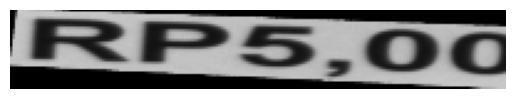

(1, 50)
(50,)
RP5,00                                            
RPF,00Ö                                           


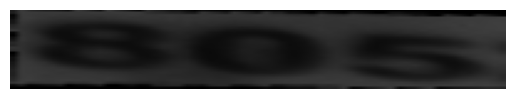

(1, 50)
(50,)
805                                               
52Y05 Ö                                           


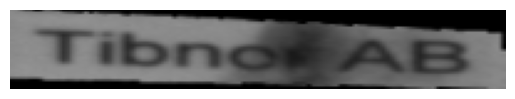

(1, 50)
(50,)
TIBNOR AB                                         
TIYNORÖAB                                         


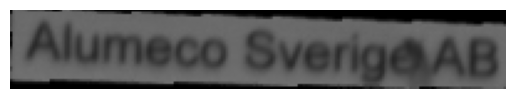

(1, 50)
(50,)
ALUMECO SVERIGE AB                                
ALYMECÖ SVERIGE AB                                


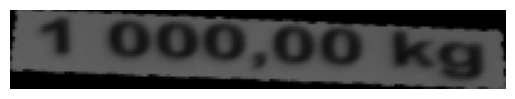

(1, 50)
(50,)
1 000,00 KG                                       
1 C00,Ö0 K                                        


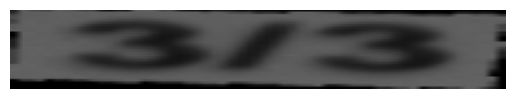

(1, 50)
(50,)
3/3                                               
3/C   Ö                                           


In [55]:
for img, label in val_ds.unbatch().take(10):
    y = np.argmax(label, 1)
    plt.imshow(img / 255)
    plt.axis('off')
    plt.show()
    plt.close()
    
    y_ = model(np.reshape(img, (1, 32, 200, 3)))
    y_ = np.argmax(y_, 2)
    print(y_.shape)
    print(y.shape)
    print(''.join([to_alphabet[a] for a in y]))
    print(''.join([to_alphabet[a] for a in y_[0]]))